# Twitter NER

## Objective:
### Twitter is a microblogging and social networking service on which users post and interact with messages known as "tweets". Every second, on average, around 6,000 tweets are tweeted on Twitter, corresponding to over 350,000 tweets sent per minute, 500 million tweets per day.
### Task is to tag and analyze tweets for better understanding of the trends and topics without being dependent on the hashtags that the users use. Many users do not use hashtags or sometimes use wrong or mis-spelled tags, so they want to completely remove this problem and create a system of recognizing important content of the tweets.

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.models import Model
#from tensorflow.keras.layers import 
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input

from distutils.version import LooseVersion as LV
from keras import __version__
from keras import backend as K

In [75]:
# Train file
in_file = 'wnut 16.txt.conll' 
count = 1
sentence = "sentence" + str(count)

with open(in_file) as f:
    sent, word, tag = [], [], []
    for line in f.readlines():
        sp = line.strip().split('\t')
        if len(sp) == 1:
            count +=1
            sentence = "sentence" + str(count)
        elif len(sp) == 2:
            sent.append(sentence)
            word.append(sp[0].lower())
            tag.append(sp[1])

In [76]:
print(len(sent))
print(len(word))
print(len(tag))

46469
46469
46469


In [77]:
in_file = 'wnut 16test.txt.conll' 
count = 1
sentence = "sentence" + str(count)

with open(in_file,encoding="utf8") as f:
    test_sent, test_word, test_tag = [], [], []
    for line in f.readlines():
        sp = line.strip().split('\t')
        if len(sp) == 1:
            count +=1
            sentence = "sentence" + str(count)
        elif len(sp) == 2:
            test_sent.append(sentence)
            test_word.append(sp[0].lower())
            test_tag.append(sp[1])

In [78]:
print(len(test_sent))
print(len(test_sent))
print(len(test_sent))

61908
61908
61908


In [79]:
# Train
data_dict = {'sentence' : sent, 'word' : word, 'tag' : tag}
data = pd.DataFrame.from_dict(data_dict)

In [80]:
# Test
test_data_dict = {'sentence' : test_sent, 'word' : test_word, 'tag' : test_tag}
test_data = pd.DataFrame.from_dict(test_data_dict)

In [81]:
data.tail()

,sentence,word,tag
46464,sentence2394,whatchu,O
46465,sentence2394,got,O
46466,sentence2394,for,O
46467,sentence2394,me,O
46468,sentence2394,@kanyewest,O


In [82]:
data[data['sentence']=='sentence1']

,sentence,word,tag
0,sentence1,@sammielynnsmom,O
1,sentence1,@tg10781,O
2,sentence1,they,O
3,sentence1,will,O
4,sentence1,be,O
5,sentence1,all,O
6,sentence1,done,O
7,sentence1,by,O
8,sentence1,sunday,O
9,sentence1,trust,O


In [10]:
print("Number of tags: {}".format(len(data.tag.unique())))
frequencies = data.tag.value_counts()
frequencies

Number of tags: 21


O                44007
B-person           449
I-other            320
B-geo-loc          276
B-other            225
I-person           215
B-company          171
I-facility         105
B-facility         104
B-product           97
I-product           80
I-musicartist       61
B-musicartist       55
B-sportsteam        51
I-geo-loc           49
I-movie             46
I-company           36
B-movie             34
B-tvshow            34
I-tvshow            31
I-sportsteam        23
Name: tag, dtype: int64

In [11]:
data.isna().sum().sum()

0

In [12]:
test_data.isna().sum().sum()

0

In [13]:
#Get the complete list of words
words = list(set(data["word"].values))
test_words = list(set(test_data["word"].values))
words.append("ENDPAD")
words = list(set(words + test_words))
#Count the size of the dictionary, after adding a special token ENDPAD that
#will be used to pad sentences
n_words = len(words); 
print("Number of different words:\t" + str(n_words))

#Count the tags
tags = list(set(data["tag"].values))
n_tags = len(tags); 
print("Number of sentences:\t" + str(len(data.sentence.unique())))
print("Number of different tags:\t" + str(n_tags))
print("List of different tags:\t" + str(set(tags)))

Number of different words:	21935
Number of sentences:	2394
Number of different tags:	21
List of different tags:	{'I-company', 'I-sportsteam', 'I-facility', 'B-geo-loc', 'I-tvshow', 'B-person', 'B-musicartist', 'B-company', 'B-other', 'O', 'I-geo-loc', 'B-facility', 'I-other', 'B-movie', 'B-product', 'I-musicartist', 'B-sportsteam', 'B-tvshow', 'I-movie', 'I-person', 'I-product'}


### So we have 2394 sentences containing 9069 different words (considering also the specail tag ENDPAD) with 21 different tags. 

### We use the SentenceGetter class to retrieve sentences with their labels.

In [84]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 0
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            #s = self.grouped["sentence: {}".format(self.n_sent)]
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None

### Sentences are loaded from the input file

The first sentence is[('@sammielynnsmom', 'O'), ('@tg10781', 'O'), ('they', 'O'), ('will', 'O'), ('be', 'O'), ('all', 'O'), ('done', 'O'), ('by', 'O'), ('sunday', 'O'), ('trust', 'O'), ('me', 'O'), ('*wink*', 'O')]


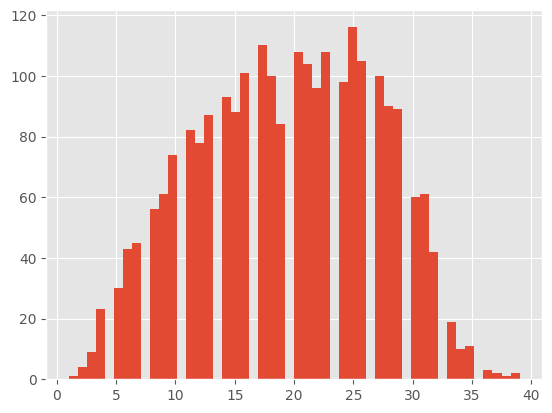

In [85]:
#Split sentences
getter = SentenceGetter(data)
#Get the first sentence
sent = getter.get_next()
print("The first sentence is" + str(sent))

#Load all sentences
sentences = getter.sentences

#Print the length distribution
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

## Conveting Sentences and Tags into vectors

### Sentences are converted into sequences of legth equal `max_len` (here 50). A **padding** is applied to shorter sentences. 

### Each word in the input dictiory is assigned to a number which will be later paired with a vector (randomly initialized). 

In [ ]:
#Maximum length of the input sequences
max_len = 50

#Word and tags in the input word and tag dictionaries are numbered
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
print("The word \"chicago\" is assigned to  " + str(word2idx["chicago"]))
print("The tag \"B-gpe\" is assigned to " + str(tag2idx["B-geo-loc"]))

#Each sentence is converted into sequences of numbers, given the above dictionaries
X = [[word2idx[w[0]] for w in s] for s in sentences]

print("\nBefor PADDING")
print("Original Sentence 1:\t" + str(sentences[1]))
print("Numerical Representation 1:\t" + str(X[1]))
print("Length of Sentence 1:" + str(len(X[1])))

#APPLY PADDING
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1)


print("The special word ENDPAD (used for padding) is assigned to:\t" + str(word2idx["ENDPAD"]))

print("\nAfter PADDING")
print("Numerical Representation 1:\t" + str(X[1]))
print("Length of Sentence 1:" + str(len(X[1])))

The word "chicago" is assigned to  2092
The tag "B-gpe" is assigned to 8

Befor PADDING
Original Sentence 1:	[('@daraobriain', 'O'), ('hmmm', 'O'), ('.', 'O'), ('cant', 'O'), ('wait', 'O'), ('.', 'O'), ('comin', 'O'), ('on', 'O'), ('thursday', 'O'), ('.', 'O'), ('first', 'O'), ('time', 'O'), ('to', 'O'), ('the', 'B-facility'), ('apollo', 'I-facility'), ('.', 'O')]
Numerical Representation 1:	[2785, 3035, 9091, 19718, 13881, 9091, 16483, 2443, 20975, 9091, 1886, 18829, 8910, 2172, 10533, 9091]
Length of Sentence 1:16
The special word ENDPAD (used for padding) is assigned to:	21551

After PADDING
Numerical Representation 1:	[ 2785  3035  9091 19718 13881  9091 16483  2443 20975  9091  1886 18829
  8910  2172 10533  9091 21934 21934 21934 21934 21934 21934 21934 21934
 21934 21934 21934 21934 21934 21934 21934 21934 21934 21934 21934 21934
 21934 21934 21934 21934 21934 21934 21934 21934 21934 21934 21934 21934
 21934 21934]
Length of Sentence 1:50


### The output labels are converted into sequences as well, with a maximum legth equals to `max_len` (here 50). A **padding** is applied to shorter sentences, assigning to padded elements the  `O` label. 

In [ ]:
# Converting output labels into number and padding
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

print("\nAfter PADDING")
print("Output labels of 1:\t" + str(y[1]))

#Converting to categorial elements
y = [to_categorical(i, num_classes=n_tags) for i in y]

print("Categorial Output labels for the first 10 tokens:\t" + str(y[1][0:10]))



After PADDING
Output labels of 1:	[7 7 7 7 7 7 7 7 7 7 7 7 7 3 0 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7]
Categorial Output labels for the first 10 tokens:	[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

print("Size of the train dataset:\t" + str(len(X_tr))+ " sequences.")
print("Size of the test dataset:\t" + str(len(X_te))+ " sequences.")

Size of the train dataset:	2154 sequences.
Size of the test dataset:	240 sequences.


In [ ]:
input = Input(shape=(max_len,))

print(input)

# The input (now sequences of numbers) are mapped into vectors of dimenaionality 50
model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)

# A dropout to the ouput is applied
model = Dropout(0.1)(model)

# Bidirectional LSTM 
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)

# A dense layer is defined to reduce the space to the same dimensionality of the output
# A softmax is applied
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  

# The model is compiled 
model = Model(input, out)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

#Print the summary
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 50), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1096750   
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 50, 21)           4221      
 ibuted)                                         

In [ ]:
batch_size = 32
epochs = 5

history = model.fit(X_tr, np.array(y_tr), batch_size = batch_size, epochs = epochs, validation_split=0.1, verbose=1)

Epoch 1/5
61/61 [==============================] - 85s 1s/step - loss: 0.6332 - accuracy: 0.9650 - val_loss: 0.1918 - val_accuracy: 0.9746
Epoch 2/5
61/61 [==============================] - 65s 1s/step - loss: 0.1479 - accuracy: 0.9799 - val_loss: 0.1642 - val_accuracy: 0.9746
Epoch 3/5
61/61 [==============================] - 63s 1s/step - loss: 0.1279 - accuracy: 0.9799 - val_loss: 0.1551 - val_accuracy: 0.9746
Epoch 4/5
61/61 [==============================] - 64s 1s/step - loss: 0.1171 - accuracy: 0.9799 - val_loss: 0.1531 - val_accuracy: 0.9746
Epoch 5/5
61/61 [==============================] - 64s 1s/step - loss: 0.1047 - accuracy: 0.9799 - val_loss: 0.1483 - val_accuracy: 0.9746


In [ ]:
hist = pd.DataFrame(history.history)

In [ ]:
hist

,loss,accuracy,val_loss,val_accuracy
0,0.633234,0.965005,0.191772,0.97463
1,0.147894,0.979876,0.164237,0.97463
2,0.127946,0.979876,0.155108,0.97463
3,0.117096,0.979876,0.153139,0.97463
4,0.104707,0.979876,0.148269,0.97463


### The results on the Train/Validation datasets

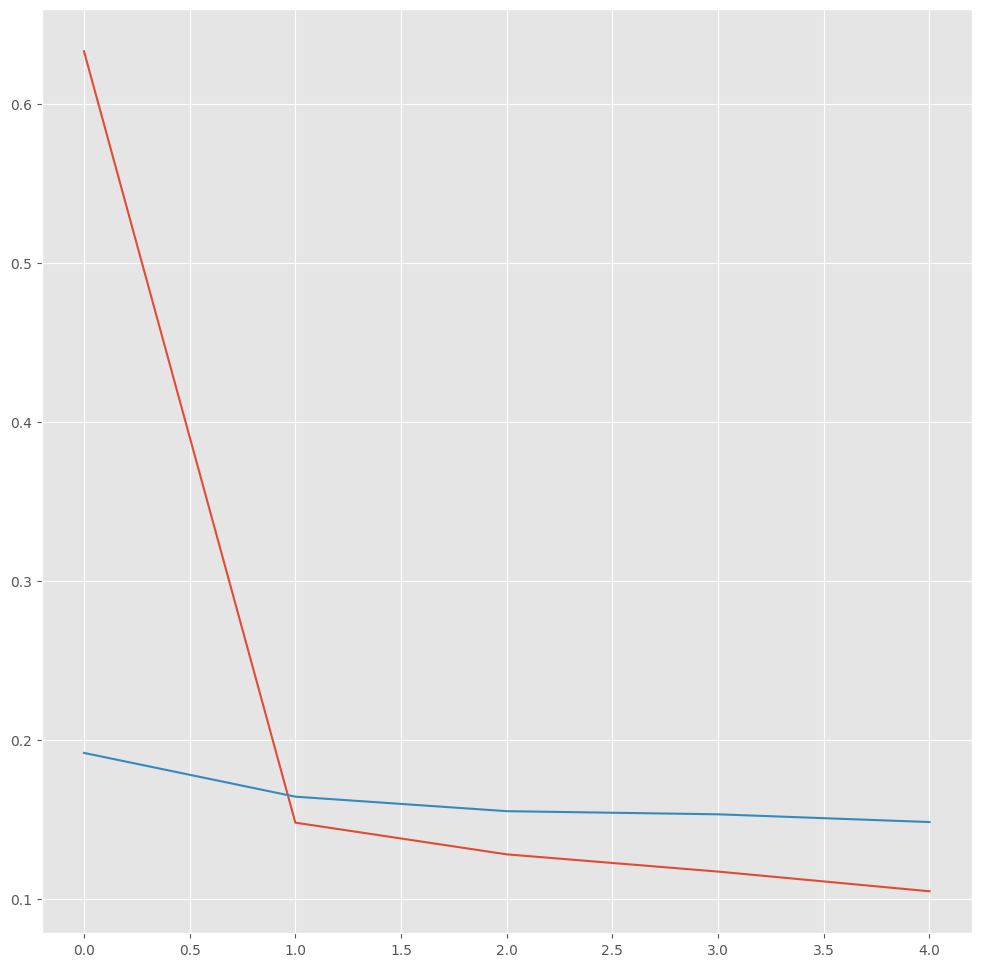

In [ ]:
plt.figure(figsize=(12,12))
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.show()

### Evaluating on test set

The first sentence is[('new', 'B-other'), ('orleans', 'I-other'), ('mother', 'I-other'), ("'s", 'I-other'), ('day', 'I-other'), ('parade', 'I-other'), ('shooting', 'O'), ('.', 'O'), ('one', 'O'), ('of', 'O'), ('the', 'O'), ('people', 'O'), ('hurt', 'O'), ('was', 'O'), ('a', 'O'), ('10-year-old', 'O'), ('girl', 'O'), ('.', 'O'), ('what', 'O'), ('the', 'O'), ('hell', 'O'), ('is', 'O'), ('wrong', 'O'), ('with', 'O'), ('people', 'O'), ('?', 'O')]


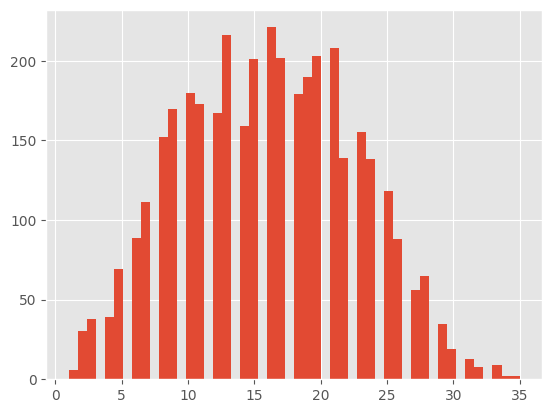

In [ ]:
#Split sentences
getter = SentenceGetter(test_data)
#Get the first sentence
sent = getter.get_next()
print("The first sentence is" + str(sent))

#Load all sentences
sentences = getter.sentences

#Print the length distribution
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [ ]:
#Each sentence is converted into sequences of numbers, given the above dictionaries
X_test = [[word2idx[w[0]] for w in s] for s in sentences]


#APPLY PADDING
X_test = pad_sequences(maxlen=max_len, sequences=X_test, padding="post", value=n_words - 1)

print("\nAfter PADDING")
print("Numerical Representation 1:\t" + str(X_test[1]))
print("Length of Sentence 1:" + str(len(X_test[1])))


After PADDING
Numerical Representation 1:	[ 6778 21152  3046   616 15629 17265  6904 19284 21934 21934 21934 21934
 21934 21934 21934 21934 21934 21934 21934 21934 21934 21934 21934 21934
 21934 21934 21934 21934 21934 21934 21934 21934 21934 21934 21934 21934
 21934 21934 21934 21934 21934 21934 21934 21934 21934 21934 21934 21934
 21934 21934]
Length of Sentence 1:50


In [ ]:
# Converting output labels into number and padding
y_test = [[tag2idx[w[1]] for w in s] for s in sentences]
y_test = pad_sequences(maxlen=max_len, sequences=y_test, padding="post", value=tag2idx["O"])

print("\nAfter PADDING")
print("Output labels of 1:\t" + str(y_test[1]))

#Converting to categorial elements
y_test = [to_categorical(i, num_classes=n_tags) for i in y_test]

print("Categorial Output labels for the first 10 tokens:\t" + str(y_test[1][0:10]))


After PADDING
Output labels of 1:	[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7]
Categorial Output labels for the first 10 tokens:	[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


### Test data accuracy is 96%

In [ ]:
model.evaluate(x=X_test, y=np.array(y_test))

121/121 [==============================] - 22s 183ms/step - loss: 0.1852 - accuracy: 0.9691


[0.18521778285503387, 0.9690649509429932]

# Ner using Transformer model:

In [38]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification

In [86]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [87]:
data.head()

,sentence,word,tag
0,sentence1,@sammielynnsmom,O
1,sentence1,@tg10781,O
2,sentence1,they,O
3,sentence1,will,O
4,sentence1,be,O


In [88]:
# let's create a new column called "sentence" which groups the words by sentence 
data['sentences'] = data[['sentence','word','tag']].groupby(['sentence'])['word'].transform(lambda x: ' '.join(x))
# let's also create a new column called "word_labels" which groups the tags by sentence 
data['word_labels'] = data[['sentence','word','tag']].groupby(['sentence'])['tag'].transform(lambda x: ','.join(x))
data.head()

,sentence,word,tag,sentences,word_labels
0,sentence1,@sammielynnsmom,O,@sammielynnsmom @tg10781 they will be all done...,"O,O,O,O,O,O,O,O,O,O,O,O"
1,sentence1,@tg10781,O,@sammielynnsmom @tg10781 they will be all done...,"O,O,O,O,O,O,O,O,O,O,O,O"
2,sentence1,they,O,@sammielynnsmom @tg10781 they will be all done...,"O,O,O,O,O,O,O,O,O,O,O,O"
3,sentence1,will,O,@sammielynnsmom @tg10781 they will be all done...,"O,O,O,O,O,O,O,O,O,O,O,O"
4,sentence1,be,O,@sammielynnsmom @tg10781 they will be all done...,"O,O,O,O,O,O,O,O,O,O,O,O"


In [89]:
labels_to_ids = {k: v for v, k in enumerate(data.tag.unique())}
ids_to_labels = {v: k for v, k in enumerate(data.tag.unique())}
labels_to_ids

{'O': 0,
 'B-geo-loc': 1,
 'B-facility': 2,
 'I-facility': 3,
 'B-movie': 4,
 'I-movie': 5,
 'B-company': 6,
 'B-product': 7,
 'B-person': 8,
 'B-other': 9,
 'I-other': 10,
 'B-sportsteam': 11,
 'I-sportsteam': 12,
 'I-product': 13,
 'I-company': 14,
 'I-person': 15,
 'I-geo-loc': 16,
 'B-tvshow': 17,
 'B-musicartist': 18,
 'I-musicartist': 19,
 'I-tvshow': 20}

In [90]:
data = data[["sentences", "word_labels"]].drop_duplicates().reset_index(drop=True)
data = data.rename(columns={'sentences': 'sentence'})
data.head()

,sentence,word_labels
0,@sammielynnsmom @tg10781 they will be all done...,"O,O,O,O,O,O,O,O,O,O,O,O"
1,made it back home to ga . it sucks not to be a...,"O,O,O,O,O,B-geo-loc,O,O,O,O,O,O,O,B-facility,I..."
2,' breaking dawn ' returns to vancouver on janu...,"O,B-movie,I-movie,O,O,O,B-geo-loc,O,O,O,O"
3,"@ls_n perhaps , but folks may find something i...","O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,..."
4,@carr0t aye been tonight - excellent,"O,O,O,O,O,O"


In [119]:
data['sentence'][16]

'man gets 20 years in murder plot against judge http://bit.ly/agb9il'

#### **Preparing the dataset and dataloader**

In [47]:
len(data)

2309

In [48]:
data.iloc[41].sentence

'is up and ready for his last day on the punt until stakes day ... #sadbuttrue'

In [49]:
data.iloc[41].word_labels

'O,O,O,O,O,O,O,O,O,O,O,O,B-other,I-other,O,O'

In [101]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 3
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [92]:
class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels 
        sentence = self.data.sentence[index].strip().split()  
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        encoding = self.tokenizer(sentence,
                             is_pretokenized=True, 
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [labels_to_ids[label] for label in word_labels] 
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

In [93]:
train_size = 0.8
train_dataset = data.sample(frac=train_size,random_state=200)
test_dataset = data.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (2309, 2)
TRAIN Dataset: (1847, 2)
TEST Dataset: (462, 2)


In [94]:
training_set[0]

{'input_ids': tensor([  101,  1030,  5977,  6834,  7106,  4931,  4086,  2100,  2031,  1037,
          2307,  1010, 19613,  2051,  1024,  1007, 24459,  2000,  2017,   999,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [95]:
for token, label in zip(tokenizer.convert_ids_to_tokens(training_set[0]["input_ids"]), training_set[0]["labels"]):
  print('{0:10}  {1}'.format(token, label))

[CLS]       -100
@           0
sean        -100
##king      -100
##ston      -100
hey         0
sweet       0
##y         -100
have        0
a           0
great       0
,           0
relaxing    0
time        0
:           0
)           -100
hugs        0
to          0
you         0
!           0
[SEP]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]       -100
[PAD]

In [96]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

### Defining the model

In [97]:
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(labels_to_ids))
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

### Training the model

In [108]:
inputs = training_set[2]
input_ids = inputs["input_ids"].unsqueeze(0)
attention_mask = inputs["attention_mask"].unsqueeze(0)
labels = inputs["labels"].unsqueeze(0).type(torch.LongTensor)

input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
labels = labels.to(device)

outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
initial_loss = outputs[0]
initial_loss

tensor(3.1377, device='cuda:0', grad_fn=<NllLossBackward0>)

In [109]:
tr_logits = outputs[1]
tr_logits.shape

torch.Size([1, 128, 21])

In [110]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [111]:
# Defining the training function on the 80% of the dataset for tuning the bert model
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [112]:
for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    train(epoch)

Training epoch: 1
Training loss per 100 training steps: 3.278249979019165
Training loss per 100 training steps: 0.7497616786472868
Training loss per 100 training steps: 0.5204234941311143
Training loss per 100 training steps: 0.43569146185816326
Training loss per 100 training steps: 0.3822518389653461
Training loss epoch: 0.3562809706875224
Training accuracy epoch: 0.9350354705862832
Training epoch: 2
Training loss per 100 training steps: 0.03478911146521568
Training loss per 100 training steps: 0.18149742349465886
Training loss per 100 training steps: 0.18351173949015526
Training loss per 100 training steps: 0.17357036357658895
Training loss per 100 training steps: 0.17097404987163414
Training loss epoch: 0.1693438391203214
Training accuracy epoch: 0.9606449911642804
Training epoch: 3
Training loss per 100 training steps: 0.0168474018573761
Training loss per 100 training steps: 0.10517272519611634
Training loss per 100 training steps: 0.10598049709800426
Training loss per 100 training

### Evaluating Model

In [113]:
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")
              
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [ids_to_labels[id.item()] for id in eval_labels]
    predictions = [ids_to_labels[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions

In [114]:
labels, predictions = valid(model, testing_loader)

Validation loss per 100 evaluation steps: 0.0781094878911972
Validation loss per 100 evaluation steps: 0.145653074996841
Validation loss per 100 evaluation steps: 0.14578141751050466
Validation Loss: 0.15153392643800803
Validation Accuracy: 0.9621296346010356


### Training Accuracy: 97.11%
### Validation Accuracy: 96.21%

# Testing on custom input:

In [121]:
sentence = "G20 summit: World leaders arrive in India's capital"

inputs = tokenizer(sentence.split(),
                    is_pretokenized=True, 
                    return_offsets_mapping=True, 
                    padding='max_length', 
                    truncation=True, 
                    max_length=MAX_LEN,
                    return_tensors="pt")

# move to gpu
ids = inputs["input_ids"].to(device)
mask = inputs["attention_mask"].to(device)
# forward pass
outputs = model(ids, attention_mask=mask)
logits = outputs[0]

active_logits = logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size*seq_len,) - predictions at the token level

tokens = tokenizer.convert_ids_to_tokens(ids.squeeze().tolist())
token_predictions = [ids_to_labels[i] for i in flattened_predictions.cpu().numpy()]
wp_preds = list(zip(tokens, token_predictions)) # list of tuples. Each tuple = (wordpiece, prediction)

prediction = []
for token_pred, mapping in zip(wp_preds, inputs["offset_mapping"].squeeze().tolist()):
  #only predictions on first word pieces are important
  if mapping[0] == 0 and mapping[1] != 0:
    prediction.append(token_pred[1])
  else:
    continue

print(sentence.split())
print(prediction)

['G20', 'summit:', 'World', 'leaders', 'arrive', 'in', "India's", 'capital']
['B-other', 'I-other', 'O', 'O', 'O', 'O', 'B-geo-loc', 'O']
